## Overview

This notebook provides an examples of how to use a deep neural network to detect ships in satellite images.

In this notebook, we will conduct the followig steps:
* Understand the problem  
* Import libraries and datasets 
* Perform Exploratory data analysis and data visualization
* Prepare data augmentation
* Understand the theory and intuition behind Deep Neural Networks
* Compile and train deep learning model 
* Assess/evaluate trained model performance

## 1. Understand the Problem

### Detecting ships in satellite images

* Satellite imagery is critical in many applications such as defense, agriculture, surveillance and intellignece. 
* This notebook aims at detecting large vessels (ships) in sea from satellite images using Artifical Intelligence.

### Data

* The dataset consists of 3553 color images belonging to 2 categories.
* Categories that are present in the data are "ships" and "no ships".

## 2. Import Libraries and Datasets

In [26]:
##install tensorflow if not on the environment
##view available packages in the environment using 'pip freeze'.  
##tensorflow is provided with the Oracle data science base environment.
# !pip install tensorflow==2.0

### Import libraries

In [27]:
import tensorflow as tf
from tensorflow import keras

In [28]:
# import the necessary packages
import json, sys, random, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import seaborn as sns

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from PIL import Image, ImageDraw 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Import and prepare data

In [30]:
# Check the number of images in the dataset

train = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir('./Data'):
  train_class = os.listdir(os.path.join('Data',i))
  for j in train_class:
    img = os.path.join('Data',i,j)
    train.append(img)
    label.append(i)

print('Number of train images : {} \n'.format(len(train)))


Number of train images : 4000 



### View training data

In [31]:
dftrain = pd.DataFrame(train)
dftrain

,0
0,Data/ship/ship_000593.png
1,Data/ship/ship_000673.png
2,Data/ship/ship_000845.png
3,Data/ship/ship_000856.png
4,Data/ship/ship_000270.png
...,...
3995,Data/no-ship/no-ship_002309.png
3996,Data/no-ship/no-ship_001850.png
3997,Data/no-ship/no-ship_000801.png
3998,Data/no-ship/no-ship_001509.png


### View classification labels 

In [32]:
dflabel = pd.DataFrame(label)
dflabel

,0
0,ship
1,ship
2,ship
3,ship
4,ship
...,...
3995,no-ship
3996,no-ship
3997,no-ship
3998,no-ship


## 3. Perform Data Exploration and Data Visualization

### Visualize the images in the dataset (pull 5 samples of each class)

* Output a plot with 2 rows and 5 columns, each containing a random image.
* This can be adjusted for a larger sample set, by changing the values for the subplot and range.

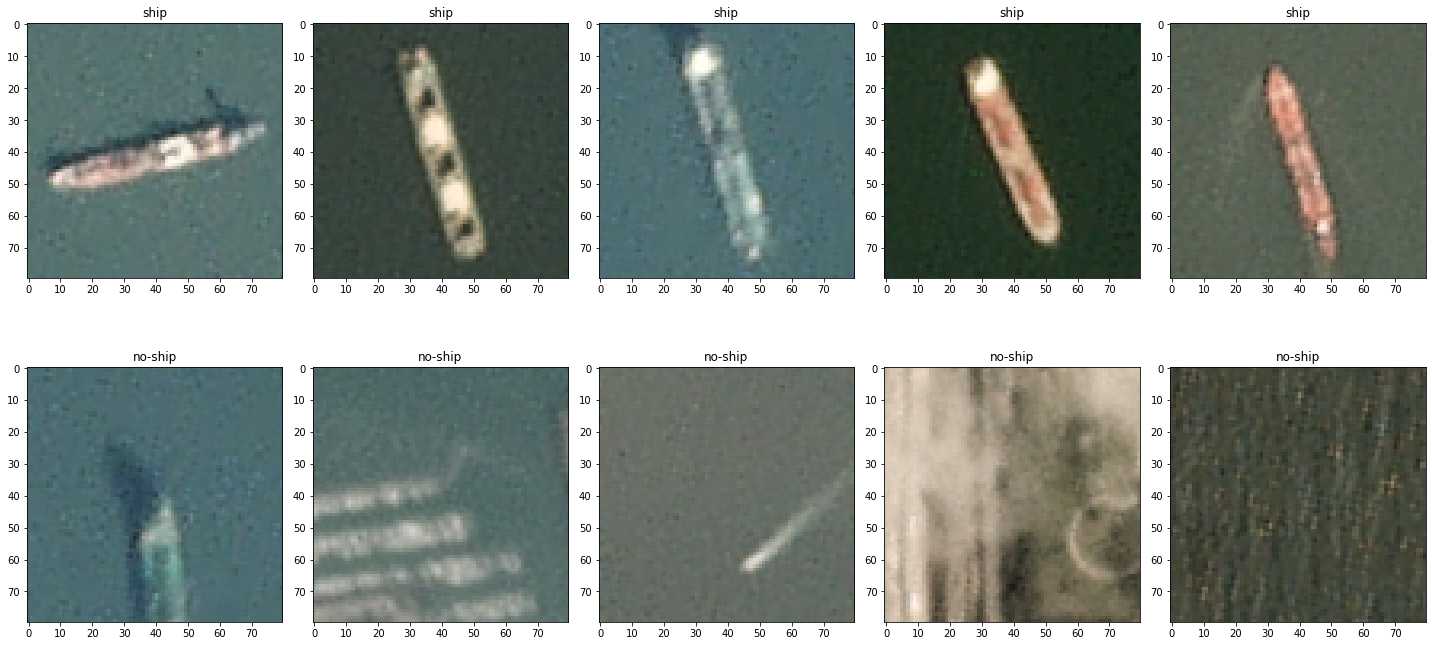

In [33]:
# Visualize the images in the dataset

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
count = 0
for i in os.listdir('./Data'):
  # get the list of images in the particualr class
  train_class = os.listdir(os.path.join('Data',i))
  # plot 5 images per class
  for j in range(5):
    img = os.path.join('Data',i,train_class[j])
    
    img = PIL.Image.open(img)
    axs[count][j].title.set_text(i)
    axs[count][j].imshow(img)  
  count += 1

fig.tight_layout()


### Pull 10 samples of each class

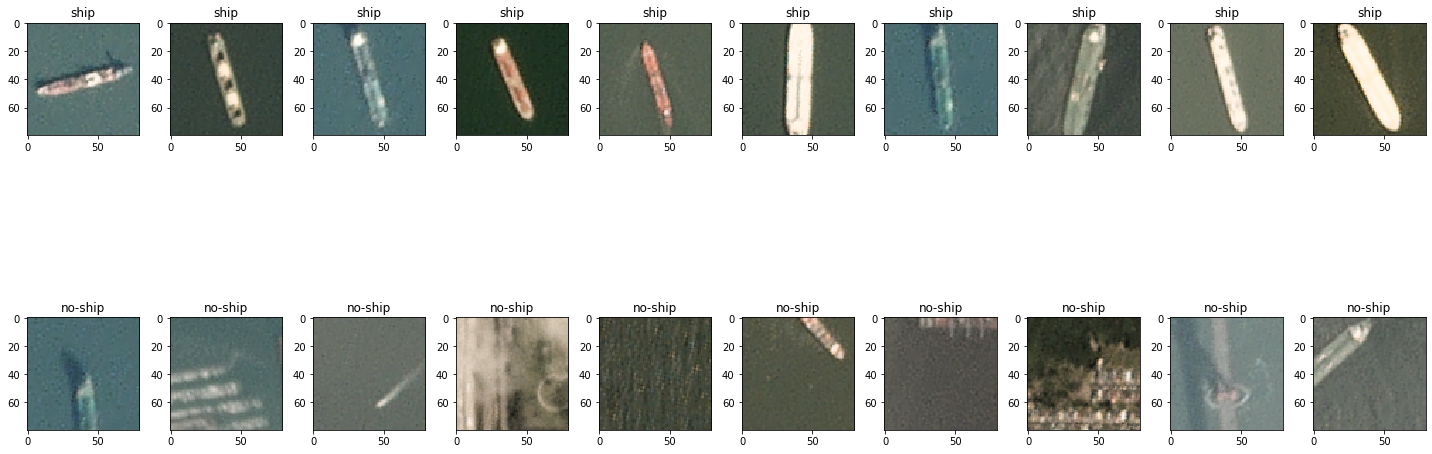

In [34]:
# Visualize the images in the dataset

fig, axs = plt.subplots(2, 10, figsize=(20, 10))
count = 0
for i in os.listdir('./Data'):
  # get the list of images in the particualr class
  train_class = os.listdir(os.path.join('Data',i))
  # plot 5 images per class
  for j in range(10):
    img = os.path.join('Data',i,train_class[j])
    
    img = PIL.Image.open(img)
    axs[count][j].title.set_text(i)
    axs[count][j].imshow(img)  
  count += 1

fig.tight_layout()

### Check the number of images in each class in the training dataset

In [35]:
# check the number of images in each class in the training dataset

No_images_per_class = []
Class_name = []
for i in os.listdir('./Data'):
  train_class = os.listdir(os.path.join('Data',i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i,len(train_class)))

Number of images in ship = 1000 

Number of images in no-ship = 3000 



### Extract ships based on their color spectrum 

* Matplotlib has a number of built-in colormaps accessible via matplotlib.cm.get_cmap.  
* Matplotlib color spectrums can be reviewed here: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
* You can use the images from the output of the color spectrum for further training.
* If you would like to try a different color map, just select one from the provided list and insret it into the code block.

In [36]:
%%html
<iframe src="https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html" width="1200" height="500"></iframe>

In [37]:
## Build the function for the color spectrum
## Extract ships based on their color spectrum 
## Check out: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

def color_spectrum_visualizer():
  fig, axs = plt.subplots(2,4, figsize=(20,10))

  ## Set the color map 
  plt.set_cmap('jet') ## You can change the color map here by switching 'jet' with another choice 
  count = 0
  for i in os.listdir('./Data'):
    # get the list of images in the particular class
    train_class = os.listdir(os.path.join('Data',i))
    # plot 5 images per class
    rand = np.random.randint(0, len(train_class))
    for j in range(3):
      img = os.path.join('Data',i,train_class[rand])
    
      img = PIL.Image.open(img)
      axs[count][j].title.set_text(i)
      channel = np.array(img)[:,:,j]
      axs[count][j].imshow(channel)  
    axs[count][3].imshow(img) 
    count += 1

  fig.tight_layout()


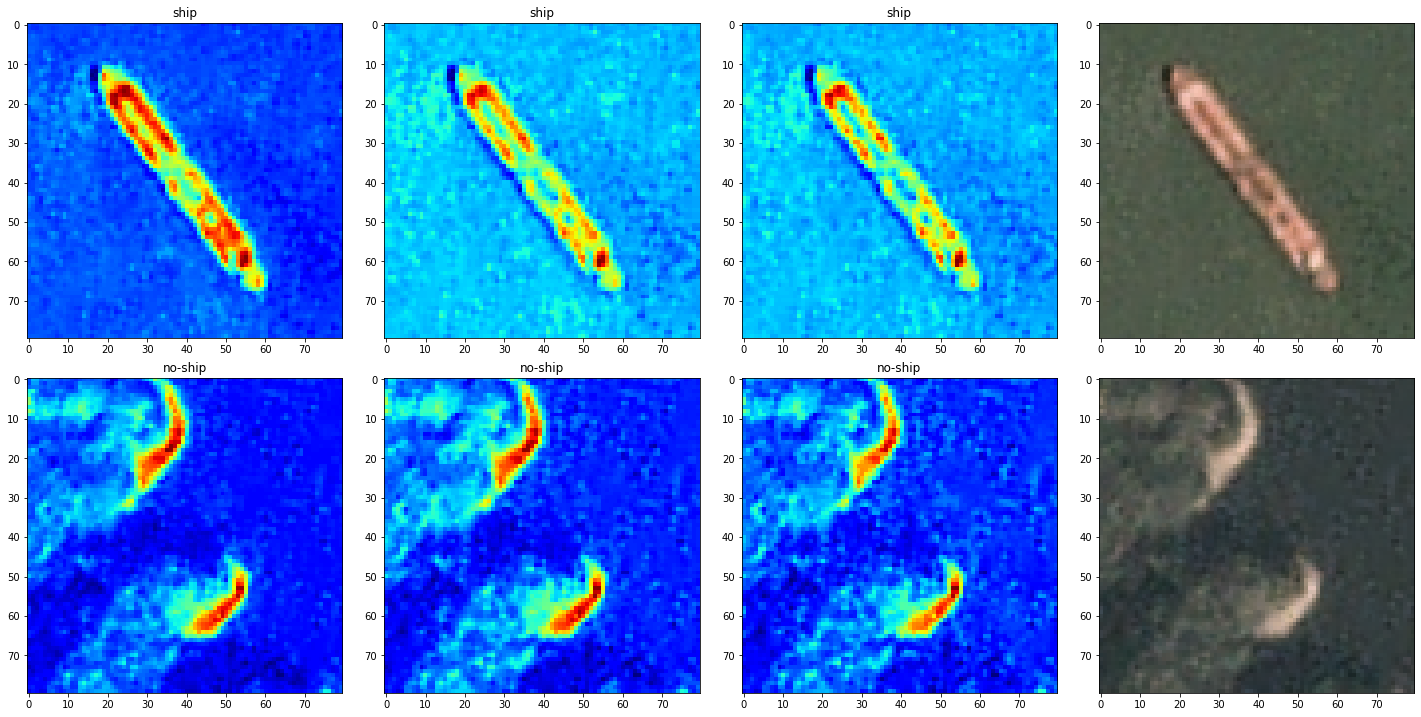

In [38]:
color_spectrum_visualizer()

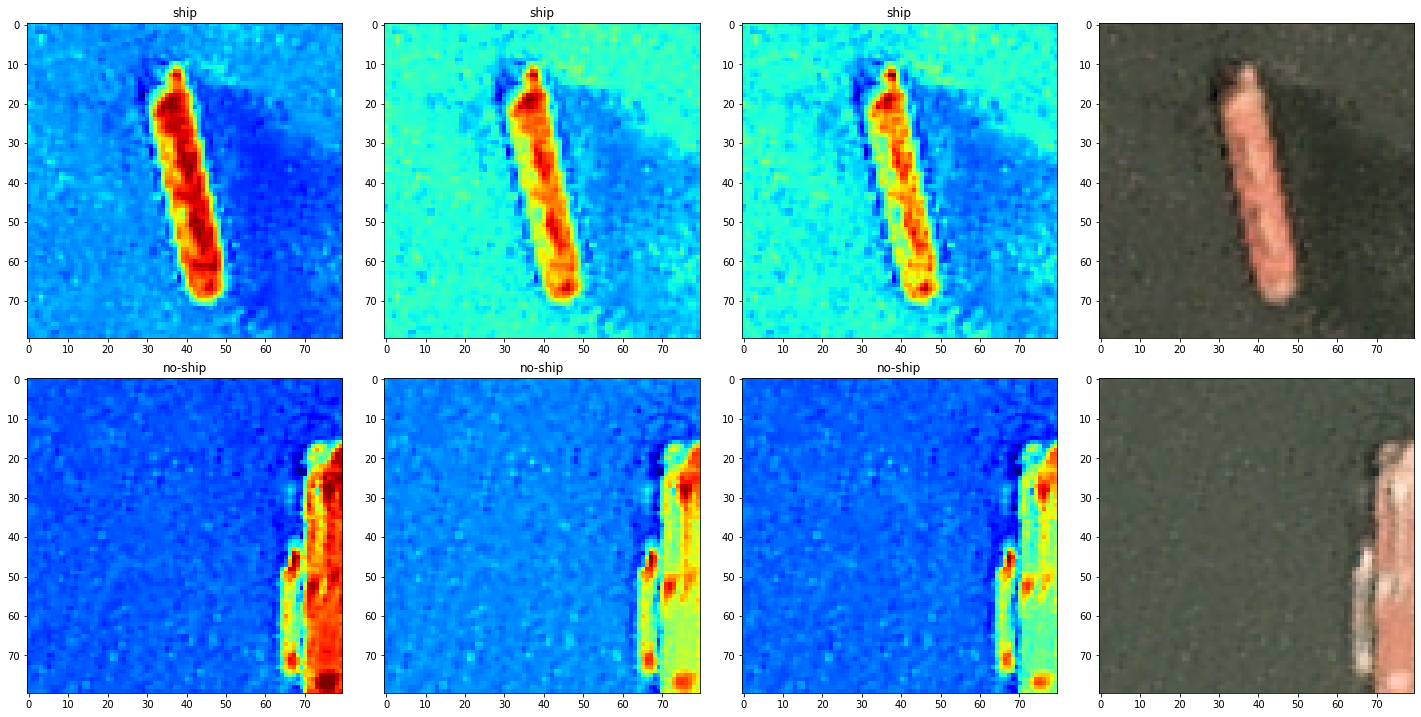

In [39]:
color_spectrum_visualizer()

### Compare numbers of images per class

<function matplotlib.pyplot.show(*args, **kw)>

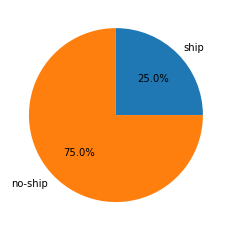

In [40]:
No_images_per_class
Class_name
fig1, ax1 = plt.subplots()
ax1.pie(No_images_per_class, labels = Class_name, autopct = '%1.1f%%')
plt.show

In [41]:
df = pd.DataFrame({'Image': train, 'Labels': label})
df

,Image,Labels
0,Data/ship/ship_000593.png,ship
1,Data/ship/ship_000673.png,ship
2,Data/ship/ship_000845.png,ship
3,Data/ship/ship_000856.png,ship
4,Data/ship/ship_000270.png,ship
...,...,...
3995,Data/no-ship/no-ship_002309.png,no-ship
3996,Data/no-ship/no-ship_001850.png,no-ship
3997,Data/no-ship/no-ship_000801.png,no-ship
3998,Data/no-ship/no-ship_001509.png,no-ship


## 4. Perform Data Augmentation and Create Data Generator

In this step we want to minimize overfitting of the model.  The objective of this step is to train the model to generalize and not memorize imagery training data.  To do this we generate variations in the data to train the model with.

Information on overfitting can be found here: https://towardsdatascience.com/overfitting-vs-underfitting-a-complete-example-d05dd7e19765

### Step 1: Split the data by 80/20

We will split the data into categoriesfor training and testing: 80% of the data will be training and 20% will be for testing.  We never want to train the model on the testing data.  

In [42]:
df = shuffle(df)

train, test = train_test_split(df, test_size = 0.2)

### Step 2: Create run-time augmentation on training and test dataset

We use ImageDataGenerator, with Tensorflow, to augment the images.  We will produce two data genarators below.  One generator for training and one for testing.  We will only use a few augmentation settings, but the code block below shows many more options that can be set.  visit Tensor flow documentaiton for more information: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
)

What is augmentation?

Image augmentation is a technique of applying different transformations to original images which results in multiple transformed copies of the same image. Each copy, however, is different from the other in certain aspects depending on the augmentation techniques you apply like shifting, rotating, flipping, etc.

Applying these small amounts of variations on the original image does not change its target class but only provides a new perspective of capturing the object in real life. 

Keras ImageDataGenerator class provides a quick and easy way to augment your images. It provides a host of different augmentation techniques like standardization, rotation, shifts, flips, brightness change, and many more. You can find more on its official documentation page:https://keras.io/api/preprocessing/image/.

The main benefit of using the Keras ImageDataGenerator class is that it is designed to provide real-time data augmentation. Meaning it is generating augmented images on the fly while your model is still in the training stage. 

ImageDataGenerator class ensures that the model receives new variations of the images at each epoch. But it only returns the transformed images and does not add it to the original corpus of images. If it was, in fact, the case, then the model would be seeing the original images multiple times which would overfit the model.

Another advantage of ImageDataGenerator is that it requires lower memory usage. This is so because without using this class, we load all the images at once. But on using it, we are loading the images in batches which saves a lot of memory.

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

In [43]:
# Create run-time augmentation on training and test dataset
# For training datagenerator, we add normalization, shear angle, zooming range and horizontal flip
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        validation_split=0.15)

# For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale=1./255)

If we look at the dataframes, we should see that the data is divided into an 80/20 split.

In [48]:
train

,Image,Labels
3411,Data/no-ship/no-ship_002981.png,no-ship
1332,Data/no-ship/no-ship_000142.png,no-ship
1587,Data/no-ship/no-ship_001475.png,no-ship
3332,Data/no-ship/no-ship_001298.png,no-ship
3378,Data/no-ship/no-ship_001890.png,no-ship
...,...,...
2146,Data/no-ship/no-ship_002865.png,no-ship
2864,Data/no-ship/no-ship_000829.png,no-ship
2143,Data/no-ship/no-ship_000794.png,no-ship
1575,Data/no-ship/no-ship_002543.png,no-ship


In [47]:
test

,Image,Labels
1680,Data/no-ship/no-ship_000350.png,no-ship
395,Data/ship/ship_000268.png,ship
2042,Data/no-ship/no-ship_000141.png,no-ship
929,Data/ship/ship_000037.png,ship
2122,Data/no-ship/no-ship_000204.png,no-ship
...,...,...
530,Data/ship/ship_000484.png,ship
2745,Data/no-ship/no-ship_002249.png,no-ship
1155,Data/no-ship/no-ship_001343.png,no-ship
985,Data/ship/ship_000967.png,ship


### Step 3: Creat data generator for training, validation and test dataset.

In addition to a training and testing dataset, we will further divided the training dataset into a validation set.  This helps us prevent overfitting withint the training data.  When the model is learning, we will run the validation dataset on the training dataset to help prevent overfitting.  We want the error in both training sets to go down.

In [49]:
# Creating datagenerator for training, validation and test dataset.

train_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    weight_col=None,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset='training',
    interpolation="nearest"
)

validation_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    weight_col=None,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset='validation',
    interpolation="nearest"
)

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory='./',
    x_col="Image",
    y_col="Labels",
    weight_col=None,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest"
)

Found 2720 validated image filenames belonging to 2 classes.
Found 479 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


## 5. Build a Deep Learning Model using Keras and Tensorflow

In [50]:
model = Sequential()

# 1st  Convolutional Layer
# input shape is 256 pixel by 256 pixel images with 3 color channels (RBG)
# specify kernel and filter size
# specify the strides, which is how many pixles you will shift the kernel ontop of the images
# relu introduces non lineratiy to the network
model.add(Conv2D(filters=96, input_shape=(256,256,3), kernel_size=(11,11), strides=(4,4),activation='relu'))

# Max Pooling (down sampling)
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),activation='relu'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),activation='relu'))

# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# 4th Convolutional Layer
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1),activation='relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1),activation='relu'))

# 6th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),activation='relu'))

# 7th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),activation='relu'))

# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096,activation='relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096,activation='relu'))
# Add Dropout: this helps prevent overfitting by improving the generalization of the network
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(1000,activation='relu'))

# 4th Fully Connected Layer
model.add(Dense(1000,activation='relu'))


# Add Dropout
model.add(Dropout(0.4))

# Output Layer: either a ship has been detected or a ship has not been detected
model.add(Dense(2,activation='softmax'))

# this model has 32 million trainable parameters

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 256)       221440    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 512)       1180160   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 512)         2

### Comparative model

Add a dense layer with 1000 neurons, print out model summary and compare performance.

In [51]:
model = Sequential()

# 1st  Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(256,256,3), kernel_size=(11,11), strides=(4,4),activation='relu'))

# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),activation='relu'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),activation='relu'))

# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# 4th Convolutional Layer
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1),activation='relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1),activation='relu'))

# 6th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),activation='relu'))

# 7th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),activation='relu'))

# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096,activation='relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096,activation='relu'))
# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(1000,activation='relu'))

# 4th Fully Connected Layer
model.add(Dense(1000,activation='relu'))

# We add this additional dense layer with 1,000 nuerons.  
model.add(Dense(1000,activation='relu'))


# Add Dropout
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 96)        34944     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 96)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 256)       221440    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 27, 256)       590080    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 512)       1180160   
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 9, 512)        

## 6. Compile and Train Deep Learnig Model

### Step 1: Compile the model:

In [52]:
# Try optimizers like adam, ndam
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

### Step 2: Specify the patience level for the model

The error for both the training and validation data should both go down.  This indicates a positive result.  
If the error for the valixation data goes up, while the error on the training data goes down this could indicate a problem and we want to exit themodel early.

In [54]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

### Step 3: Train the model

In this example we will only train the data for 1 epoch, becuase of time. In practice, we want to train the network 20 or more times.
Generally, training the model takes a very long time. 2 epochs can take up to 20 minutes for this scenario.  The training time for this notebook is much faster, due to using Oracle GPU resources.

In [63]:
# Change the value of epoch to 30
history = model.fit(train_generator, steps_per_epoch = train_generator.n // 32, epochs = 2, validation_data= validation_generator, 
                    validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

Epoch 1/2
85/85 [==============================] - ETA: 0s - loss: 0.5646 - accuracy: 0.7485
Epoch 00001: val_loss did not improve from 0.55267
85/85 [==============================] - 44s 513ms/step - loss: 0.5646 - accuracy: 0.7485 - val_loss: 0.5623 - val_accuracy: 0.7500
Epoch 2/2
85/85 [==============================] - ETA: 0s - loss: 0.5617 - accuracy: 0.7529
Epoch 00002: val_loss did not improve from 0.55267
85/85 [==============================] - 44s 515ms/step - loss: 0.5617 - accuracy: 0.7529 - val_loss: 0.5575 - val_accuracy: 0.7545


### Step 4: Plot the loss and validation loss

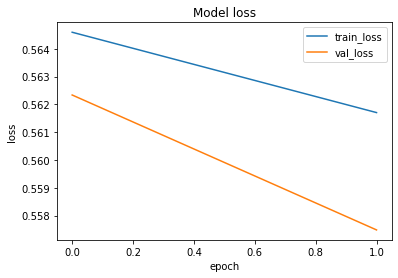

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()


## 7. Assess the Performance of the Trained Model

### Evaluate the performance of the model

In [66]:
# Evaluate the performance of the model
evaluate = model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

25/25 [==============================] - 1s 49ms/step - loss: 0.5678 - accuracy: 0.7450
Accuracy Test : 0.7450000047683716


### Assign label names to the corresponding indexes

In [68]:
# assigning label names to the corresponding indexes
labels = {0: 'no-ship', 1: 'ship'}

### Load images and their predictions 

In [70]:
# loading images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
#import cv2

prediction = []
original = []
image = []
count = 0

for item in range(len(test)):
  #code to open the image
  img= PIL.Image.open(test['Image'].tolist()[item])
  #resizing the image to (256,256)
  img = img.resize((256,256))
  #appending image to the image list
  image.append(img)
  #converting image to array
  img = np.asarray(img, dtype= np.float32)
  #normalizing the image
  img = img / 255
  #reshaping the image in to a 4D array
  img = img.reshape(-1,256,256,3)
  #making prediction of the model
  predict = model.predict(img)
  #getting the index corresponding to the highest value in the prediction
  predict = np.argmax(predict)
  #appending the predicted class to the list
  prediction.append(labels[predict])
  #appending original class to the list
  original.append(test['Labels'].tolist()[item])


### Get the test accuracy

In [71]:
# Getting the test accuracy 
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.745


### Show images from the testing dataset

Here we can physical see how well the model performed against the test data.

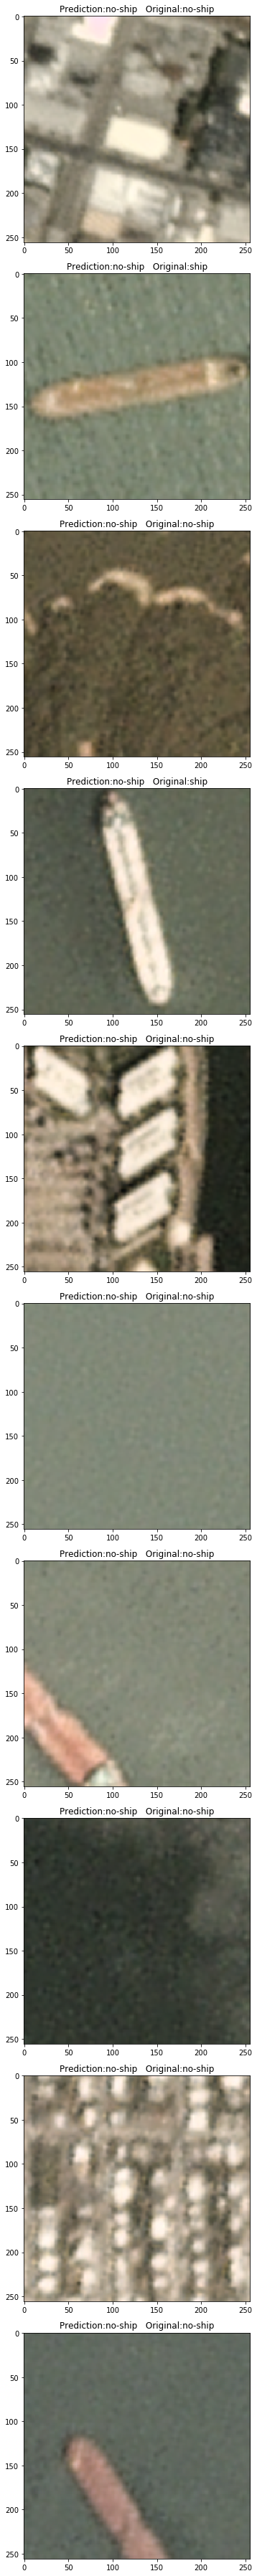

In [73]:
fig, axs = plt.subplots(10,1, figsize=(50,50))
count = 0
for i in range(10):
  j = random.randint(0,len(image))
  axs[count].title.set_text("Prediction:" + prediction[j] +"   Original:" + original[j])
  axs[count].imshow(image[j])  
  count += 1

fig.tight_layout()

MINI CHALLENGE #5: 
 - print out the classification report 
 - print out the confusion matrix and comment on the model performance


### Print out the classification report 

In [74]:
# classification report
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

     no-ship       0.74      1.00      0.85       596
        ship       0.00      0.00      0.00       204

    accuracy                           0.74       800
   macro avg       0.37      0.50      0.43       800
weighted avg       0.56      0.74      0.64       800



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Print out the confusion matrix and comment on the model performance

Text(0.5, 1, 'Confusion_matrix')

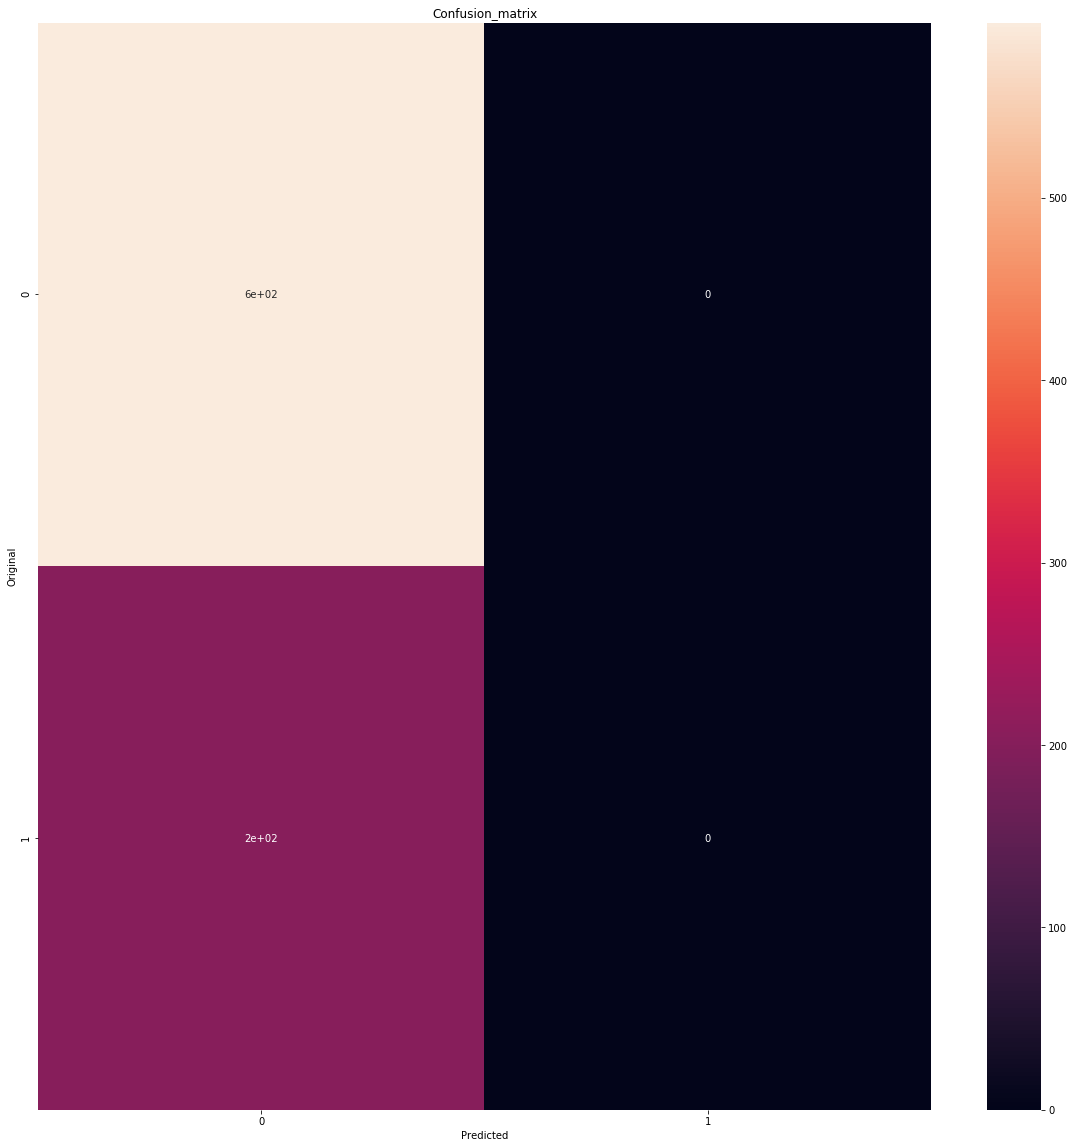

In [76]:
# plotting confusion matrix
plt.figure(figsize=(20,20))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')